In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import json
import pickle

# Load the datasets
vis_main = fits.open('../data/vis_main_filtered.fits')[1].data

df = pd.DataFrame(np.array(vis_main).byteswap().newbyteorder())

In [2]:
import sys
import os

src_path = os.path.abspath("../src")
sys.path.insert(0, src_path)

import pandas as pd
from tqdm import tqdm
from bic_vs_components import compute_bic_vs_n_components
from gmm_analysis import fit_gmm_fixed_components, plot_gmm_with_contributions, extract_gmm_parameters


/Users/raunaqrai/miniforge3/envs/research_project_MW_GMM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Count how many entries have |z| < 2.5
num_z_below_2_5 = (df['Z'].abs() < 2.5).sum()
print(f"Number of stars with |z| < 2.5 kpc: {num_z_below_2_5}")

# Calculate the fraction of the total
fraction_z_below_2_5 = num_z_below_2_5 / len(df)
print(f"Fraction of stars with |z| < 2.5 kpc: {fraction_z_below_2_5:.2%}")


Number of stars with |z| < 2.5 kpc: 3304963
Fraction of stars with |z| < 2.5 kpc: 97.01%


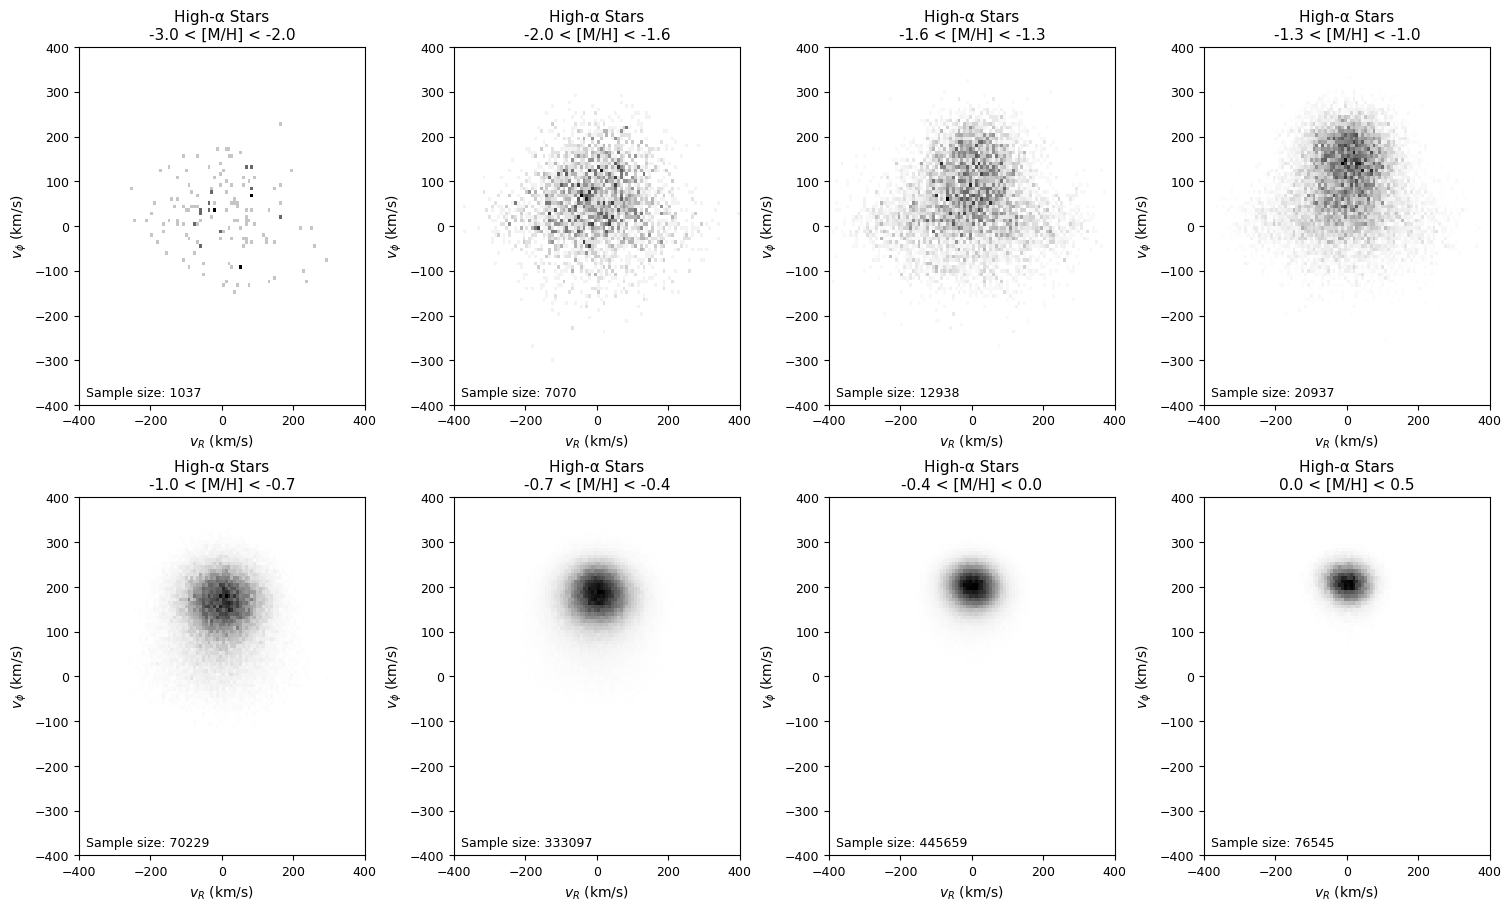

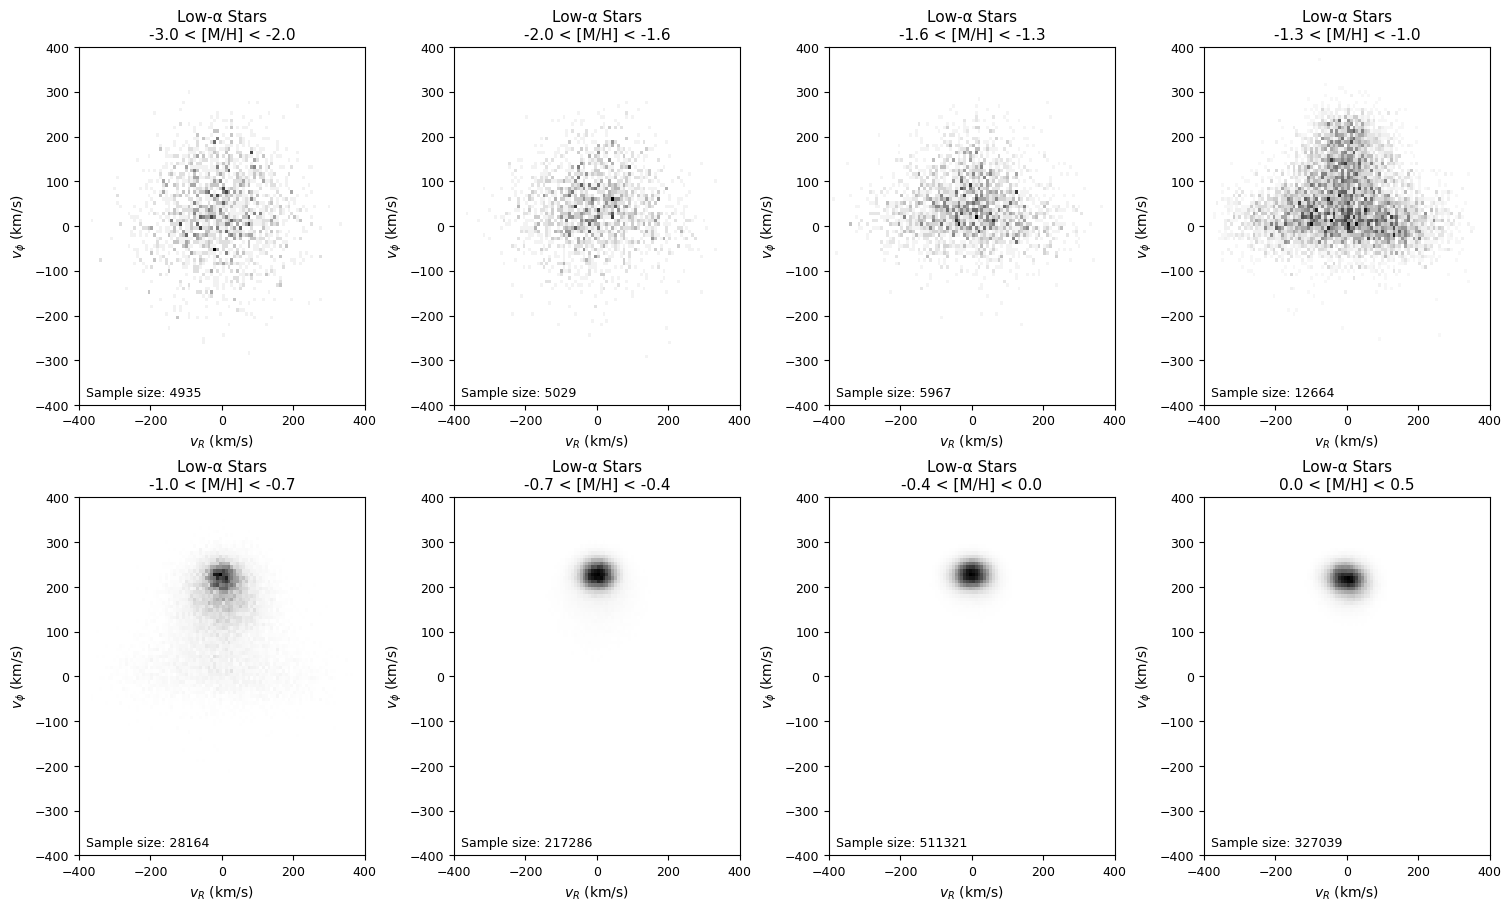

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

def define_alpha_sequences(df, alpha_col='aom_xp', feh_col='mh_xgboost'):
    alpha = df[alpha_col]
    feh = df[feh_col]

    high_alpha = (
        ((feh < -0.6) & (alpha > 0.28)) |
        ((feh >= -0.6) & (feh <= 0.125) & (alpha > (-0.25 * feh + 0.13))) |
        ((feh > 0.125) & (alpha > 0.1))
    )

    low_alpha = (
        ((feh < -0.8) & (alpha < 0.21)) |
        ((feh >= -0.8) & (feh <= 0.07) & (alpha < (-0.21 * feh + 0.045))) |
        ((feh > 0.07) & (alpha < 0.03))
    )

    return df[high_alpha], df[low_alpha]

def plot_vr_vphi_by_metallicity(df, title_prefix, save_prefix=None):
    # Define metallicity bins and labels
    metallicity_bins = [-3.0, -2.0, -1.6, -1.3, -1.0, -0.7, -0.4, 0.0, 0.5]
    bin_labels = [
        "-3.0 < [M/H] < -2.0", "-2.0 < [M/H] < -1.6", "-1.6 < [M/H] < -1.3", "-1.3 < [M/H] < -1.0",
        "-1.0 < [M/H] < -0.7", "-0.7 < [M/H] < -0.4", "-0.4 < [M/H] < 0.0", "0.0 < [M/H] < 0.5"
    ]

    bins = 100
    x_limits = (-400, 400)
    y_limits = (-400, 400)

    fig, axes = plt.subplots(2, 4, figsize=(15, 9), constrained_layout=True)

    for i, (low, high) in enumerate(zip(metallicity_bins[:-1], metallicity_bins[1:])):
        df_filtered = df[(df["mh_xgboost"] > low) & (df["mh_xgboost"] <= high)]
        df_filtered = df_filtered.dropna(subset=["v_R", "v_phi"])

        # Compute 2D histogram
        H, xedges, yedges = np.histogram2d(
            df_filtered["v_R"],
            df_filtered["v_phi"],
            bins=bins, range=[x_limits, y_limits], density=True
        )

        # Min-max normalization
        H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5
        H_max = np.max(H) if np.max(H) > 0 else 1
        H_normalized = (H - H_min) / (H_max - H_min)
        H_normalized = np.clip(H_normalized, 0, 1)

        ax = axes[i // 4, i % 4]
        im = ax.pcolormesh(xedges, yedges, H_normalized.T, cmap="Greys", shading='auto')

        ax.set_title(f"{title_prefix}\n{bin_labels[i]}", fontsize=11)
        ax.set_xlabel(r"$v_R$ (km/s)", fontsize=10)
        ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=10)
        ax.tick_params(axis="both", labelsize=9)
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.text(x_limits[0] + 20, y_limits[0] + 20, f"Sample size: {len(df_filtered)}", fontsize=9)

    if save_prefix:
        plt.savefig(f"../figures/{save_prefix}.png", dpi=300)
    plt.show()

# Define high and low alpha populations
df_high, df_low = define_alpha_sequences(df)

# Plot for both populations
plot_vr_vphi_by_metallicity(df_high, title_prefix="High-α Stars",save_prefix='high_alpha')
plot_vr_vphi_by_metallicity(df_low, title_prefix="Low-α Stars",save_prefix='low_alpha')


In [5]:
def plot_bic_vs_n_components(BIC_values, save_prefix=None):
    """
    Plots BIC vs. Number of Components.

    Args:
    - BIC_values: Dictionary with BIC values for each component count.
    - save_prefix: Optional filename prefix for saving the figure.
    """
    num_components = sorted(BIC_values.keys())  # Sorted list of component numbers

    smallest_bic = [min(BIC_values[N]) for N in num_components]
    median_bic = [np.median(BIC_values[N]) for N in num_components]
    largest_bic = [max(BIC_values[N]) for N in num_components]
    q25_bic = [np.percentile(BIC_values[N], 25) for N in num_components]  # 25th percentile
    q75_bic = [np.percentile(BIC_values[N], 75) for N in num_components]  # 75th percentile

    min_bic = min(smallest_bic)
    min_index = smallest_bic.index(min_bic)
    best_n_components = num_components[min_index]


    plt.figure(figsize=(5, 6))
    plt.plot(num_components, smallest_bic, 'k-', label='Smallest BIC')
    plt.plot(num_components, q25_bic, 'g-.', label='25th Percentile BIC')
    plt.plot(num_components, median_bic, 'b--', label='Median BIC')
    plt.plot(num_components, q75_bic, '-.', label='75th Percentile BIC')
    plt.plot(num_components, largest_bic, 'r:', label='Largest BIC')
    plt.plot(best_n_components, min_bic, 'ro', markersize=8, label='Minimum BIC')

    plt.xlabel("Number of GMM Components",fontsize=14)
    plt.ylabel("{BIC Value}",fontsize=14)
    plt.title(f"{save_prefix}")
    plt.legend()
    plt.grid(True)
    if save_prefix:
        plt.savefig(f"../figures/{save_prefix}.png", dpi=300)
    plt.show()

In [6]:
df_vmp_high = df_high[(df_high['mh_xgboost'] >= -3.0) & (df_high['mh_xgboost'] < -2.0)]
df_imp_high = df_high[(df_high['mh_xgboost'] >= -2.0) & (df_high['mh_xgboost'] < -1.6)]
df_mp1_high = df_high[(df_high['mh_xgboost'] >= -1.6) & (df_high['mh_xgboost'] < -1.3)]
df_mp2_high = df_high[(df_high['mh_xgboost'] >= -1.3) & (df_high['mh_xgboost'] < -1.0)]

df_vmp_low = df_low[(df_low['mh_xgboost'] >= -3.0) & (df_low['mh_xgboost'] < -2.0)]
df_imp_low = df_low[(df_low['mh_xgboost'] >= -2.0) & (df_low['mh_xgboost'] < -1.6)]
df_mp1_low = df_low[(df_low['mh_xgboost'] >= -1.6) & (df_low['mh_xgboost'] < -1.3)]
df_mp2_low = df_low[(df_low['mh_xgboost'] >= -1.3) & (df_low['mh_xgboost'] < -1.0)]

In [11]:
bic_vmp_high_alpha = compute_bic_vs_n_components(df_vmp_high, max_components=8, n_init=50)

with open("../models/bic_vmp_high_alpha.json", "w") as f:
    json.dump(bic_vmp_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs:  75%|███████▌  | 6/8 [07:32<02:13, 66.65s/it]/Users/raunaqrai/miniforge3/envs/research_project_MW_GMM/lib/python3.10/site-packages/scipy/_lib/_util.py:440: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  return fun(*args, **kwargs)
Fitting GMMs: 100%|██████████| 8/8 [09:34<00:00, 71.79s/it]


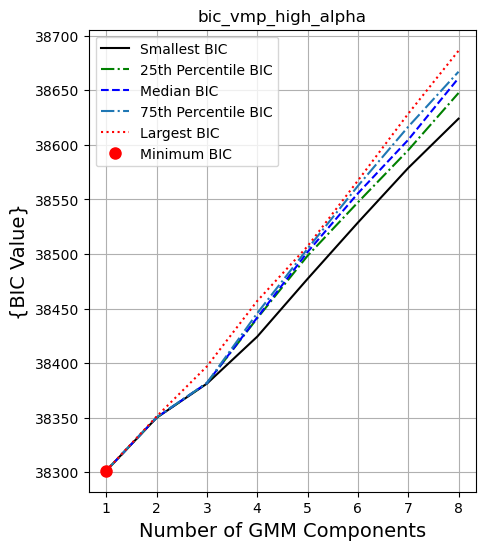

In [33]:
plot_bic_vs_n_components(bic_vmp_high_alpha, save_prefix='bic_vmp_high_alpha')

In [13]:
bic_imp_high_alpha = compute_bic_vs_n_components(df_imp_high, max_components=8, n_init=50)

with open("../models/bic_imp_high_alpha.json", "w") as f:
    json.dump(bic_imp_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [13:03<00:00, 97.91s/it] 


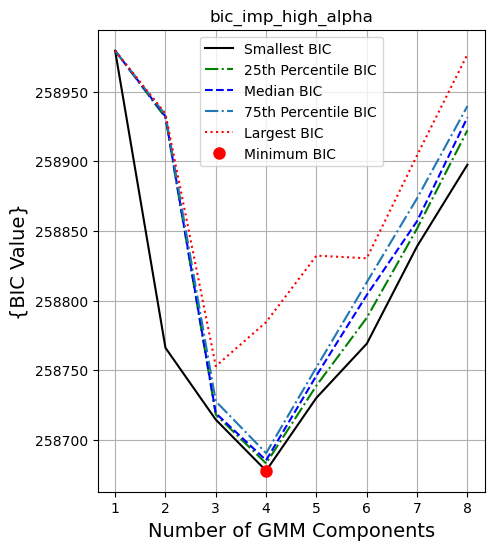

In [34]:
plot_bic_vs_n_components(bic_imp_high_alpha,save_prefix='bic_imp_high_alpha')

In [15]:
bic_mp1_high_alpha = compute_bic_vs_n_components(df_mp1_high, max_components=8, n_init=50)

with open("../models/bic_mp1_high_alpha.json", "w") as f:
    json.dump(bic_mp1_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [19:36<00:00, 147.10s/it]


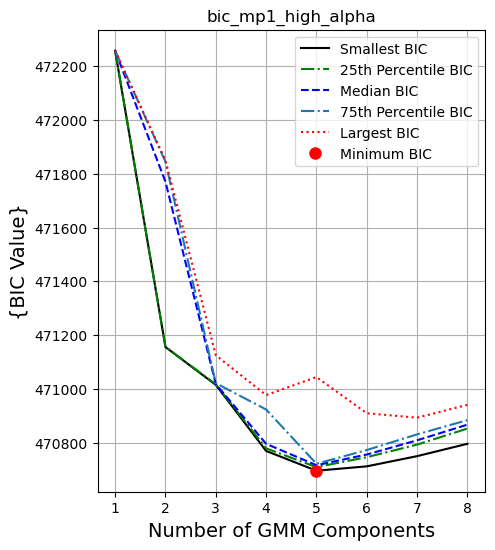

In [35]:
plot_bic_vs_n_components(bic_mp1_high_alpha,save_prefix='bic_mp1_high_alpha')

In [17]:
bic_mp2_high_alpha = compute_bic_vs_n_components(df_mp2_high, max_components=8, n_init=50)

with open("../models/bic_mp2_high_alpha.json", "w") as f:
    json.dump(bic_mp2_high_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [24:56<00:00, 187.03s/it]


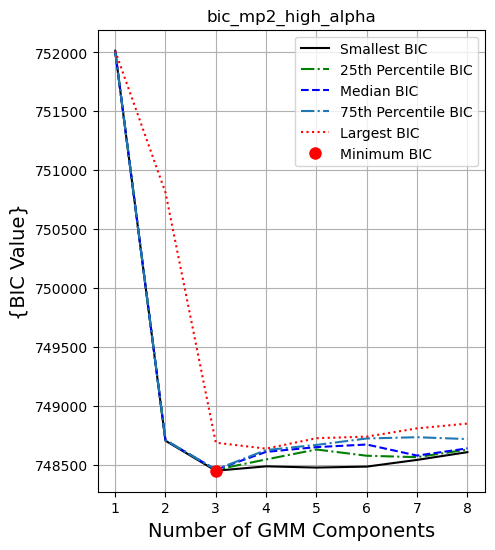

In [36]:
plot_bic_vs_n_components(bic_mp2_high_alpha,save_prefix='bic_mp2_high_alpha')

In [19]:
bic_vmp_low_alpha = compute_bic_vs_n_components(df_vmp_low, max_components=8, n_init=50)

with open("../models/bic_vmp_low_alpha.json", "w") as f:
    json.dump(bic_vmp_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [11:39<00:00, 87.47s/it] 


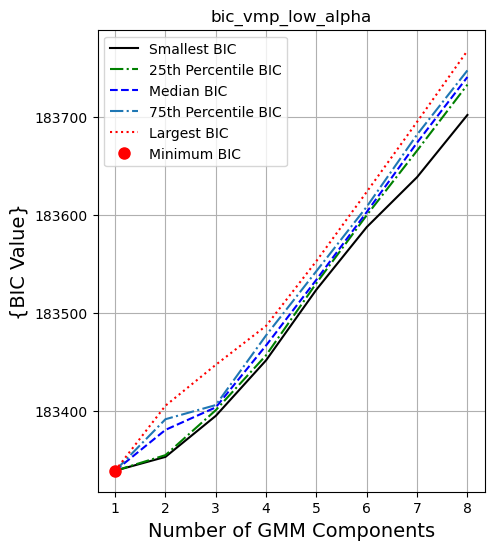

In [37]:
plot_bic_vs_n_components(bic_vmp_low_alpha,save_prefix='bic_vmp_low_alpha')

In [21]:
bic_imp_low_alpha = compute_bic_vs_n_components(df_imp_low, max_components=8, n_init=50)

with open("../models/bic_imp_low_alpha.json", "w") as f:
    json.dump(bic_imp_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [12:13<00:00, 91.67s/it] 


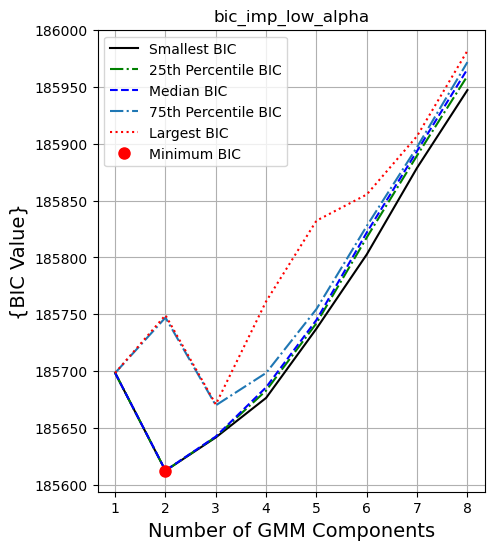

In [38]:
plot_bic_vs_n_components(bic_imp_low_alpha,save_prefix='bic_imp_low_alpha')

In [23]:
bic_mp1_low_alpha = compute_bic_vs_n_components(df_mp1_low, max_components=8, n_init=50)

with open("../models/bic_mp1_low_alpha.json", "w") as f:
    json.dump(bic_mp1_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [12:18<00:00, 92.33s/it] 


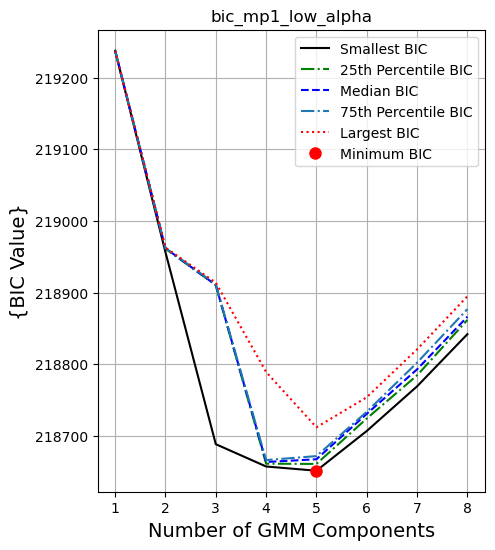

In [39]:
plot_bic_vs_n_components(bic_mp1_low_alpha,save_prefix='bic_mp1_low_alpha')

In [25]:
bic_mp2_low_alpha = compute_bic_vs_n_components(df_mp2_low, max_components=8, n_init=50)

with open("../models/bic_mp2_low_alpha.json", "w") as f:
    json.dump(bic_mp2_low_alpha, f)


Computing BIC for different numbers of components...


Fitting GMMs: 100%|██████████| 8/8 [16:12<00:00, 121.60s/it]


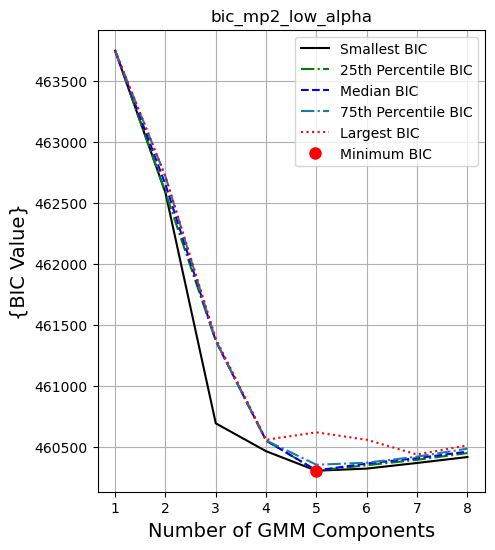

In [40]:
plot_bic_vs_n_components(bic_mp2_low_alpha,save_prefix='bic_mp2_low_alpha')

In [42]:
gmm_vmp_high = fit_gmm_fixed_components(df_vmp_high, n_components=1, n_init=100)

with open("../models/gmm_vmp_high.pkl", "wb") as f:
    pickle.dump(gmm_vmp_high, f)

Fitting GMM with 1 components: 100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


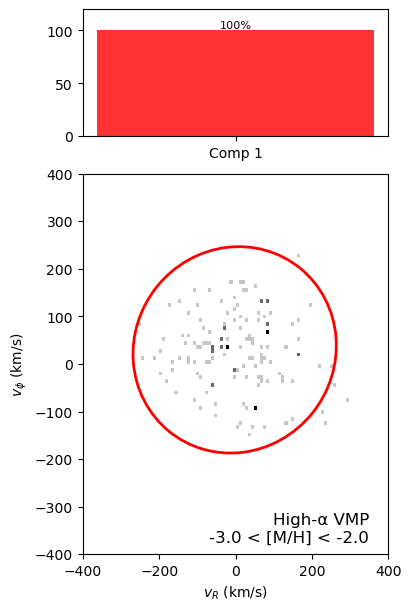


High-α VMP (-3.0 < [M/H] < -2.0) (1033 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo    100.0      -2.4     133.08      29.8       108.47      6.8      104.61  


In [77]:
colors = ["red"]

plot_gmm_with_contributions(
    df_bin=df_vmp_high,
    gmm=gmm_vmp_high,
    bin_label="High-α VMP",
    metallicity_range="-3.0 < [M/H] < -2.0",
    label="vmp_high_alpha_k1",
    component_colors=colors,
)

summary = extract_gmm_parameters(gmm_vmp_high, df_vmp_high, label="High-α VMP (-3.0 < [M/H] < -2.0)")
print(summary)

In [44]:
#imp high alpha component 4

gmm_imp_high = fit_gmm_fixed_components(df_imp_high, n_components=4, n_init=100)

with open("../models/gmm_imp_high.pkl", "wb") as f:
    pickle.dump(gmm_imp_high, f)

Fitting GMM with 4 components: 100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


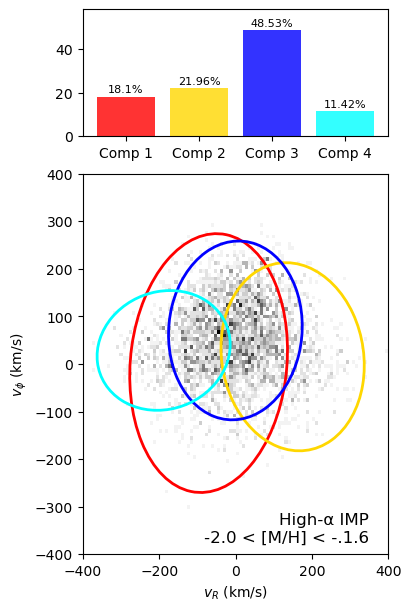


High-α IMP (-2.0 < [M/H] < -1.6) (7050 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     18.1      -70.63    103.27      2.00       136.02     -13.00    120.01  
  Prograde halo     22.0      149.33     93.80     15.31        98.88      10.40    106.66  
         GS/E 1     11.4     -188.39     87.12     28.59        62.94      -0.62     97.96  
         GS/E 2     48.5       -0.56     87.54     70.63        93.97      -1.29     66.22  


In [78]:
colors = ["red", "gold", "blue", "aqua"]

plot_gmm_with_contributions(
    df_bin=df_imp_high,
    gmm=gmm_imp_high,
    bin_label="High-α IMP",
    metallicity_range="-2.0 < [M/H] < -.1.6",
    label="imp_high_alpha_k4",
    component_colors=colors,
)

summary = extract_gmm_parameters(gmm_imp_high, df_imp_high, label="High-α IMP (-2.0 < [M/H] < -1.6)")
print(summary)

In [51]:
#mp1 high alpha component 5

gmm_mp1_high = fit_gmm_fixed_components(df_mp1_high, n_components=5, n_init=100)

with open("../models/gmm_mp1_high.pkl", "wb") as f:
    pickle.dump(gmm_mp1_high, f)

Fitting GMM with 5 components:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting GMM with 5 components: 100%|██████████| 100/100 [05:43<00:00,  3.44s/it]


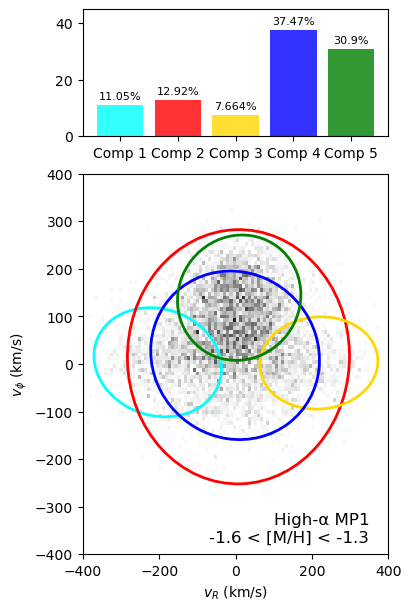


High-α MP1 (-1.6 < [M/H] < -1.3) (12899 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo      7.7      218.01     77.33       2.25       48.52      -2.09    104.19  
  Prograde halo     11.0     -203.90     83.50       3.74       57.34       5.61     97.30  
         GS/E 1     12.9        7.52    145.38      15.28      133.61     -10.39    133.93  
         GS/E 2     37.5       -1.29    110.47      18.28       88.55      -3.74     71.46  
     Thick Disc     30.9        9.38     80.76     139.48       65.87       5.41     69.98  


In [79]:
colors = ["aqua", "red", "gold", "blue", "green"]

plot_gmm_with_contributions(
    df_bin=df_mp1_high,
    gmm=gmm_mp1_high,
    bin_label="High-α MP1",
    metallicity_range="-1.6 < [M/H] < -1.3",
    label="mp1_high_alpha_k5"
    , component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp1_high, df_mp1_high, label="High-α MP1 (-1.6 < [M/H] < -1.3)")
print(summary)

In [57]:
#mp2 high alpha component 3

gmm_mp2_high = fit_gmm_fixed_components(df_mp2_high, n_components=3, n_init=100)

with open("../models/gmm_mp2_high.pkl", "wb") as f:
    pickle.dump(gmm_mp2_high, f)


Fitting GMM with 3 components: 100%|██████████| 100/100 [05:24<00:00,  3.25s/it]


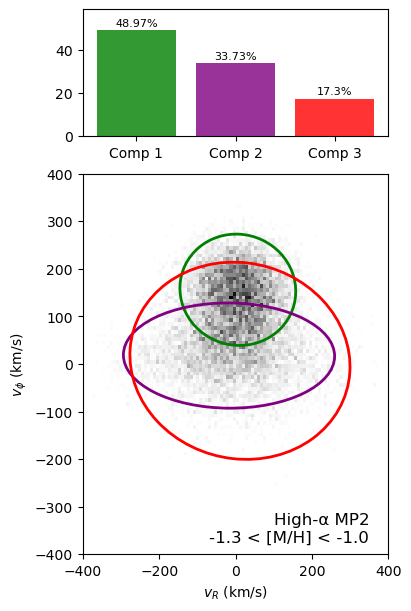


High-α MP2 (-1.3 < [M/H] < -1.0) (20925 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     17.3      11.44    144.07       6.85      103.63     -6.84     105.99  
  Prograde halo     33.7     -17.25    138.25      17.80       55.30     -1.66      78.42  
         GS/E 1     49.0       5.87     75.82     156.06       58.51     -0.43      66.60  


In [80]:
colors = ["green", "purple", "red"]

plot_gmm_with_contributions(
    df_bin=df_mp2_high,
    gmm=gmm_mp2_high,
    bin_label="High-α MP2",
    metallicity_range="-1.3 < [M/H] < -1.0",
    label="mp2_high_alpha_k6",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp2_high, df_mp2_high, label="High-α MP2 (-1.3 < [M/H] < -1.0)")
print(summary)

In [63]:
#vmp low alpha component 1

gmm_vmp_low = fit_gmm_fixed_components(df_vmp_low, n_components=1, n_init=100)

with open("../models/gmm_vmp_low.pkl", "wb") as f:
    pickle.dump(gmm_vmp_low, f)


Fitting GMM with 1 components: 100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


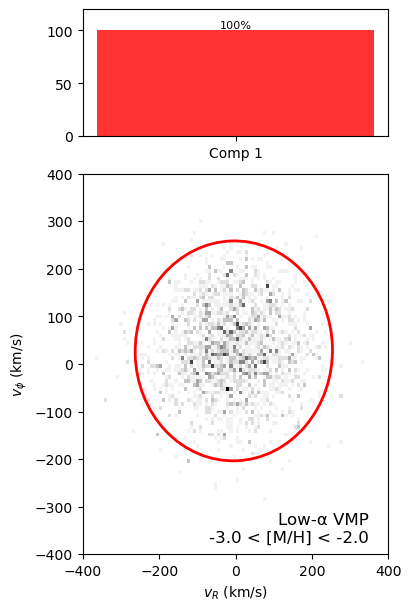


Low-α VMP (-3.0 < [M/H] < -2.0) (4923 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo    100.0     -4.62     129.15     27.66       115.57      1.01     111.32  


In [81]:
colors= ["red"]

plot_gmm_with_contributions(
    df_bin=df_vmp_low,
    gmm=gmm_vmp_low,
    bin_label="Low-α VMP",
    metallicity_range="-3.0 < [M/H] < -2.0",
    label="vmp_low_alpha_k1",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_vmp_low, df_vmp_low, label="Low-α VMP (-3.0 < [M/H] < -2.0)")
print(summary)

In [65]:
#imp low alpha component 2
gmm_imp_low = fit_gmm_fixed_components(df_imp_low, n_components=2, n_init=100)

with open("../models/gmm_imp_low.pkl", "wb") as f:
    pickle.dump(gmm_imp_low, f)

Fitting GMM with 2 components: 100%|██████████| 100/100 [03:57<00:00,  2.37s/it]


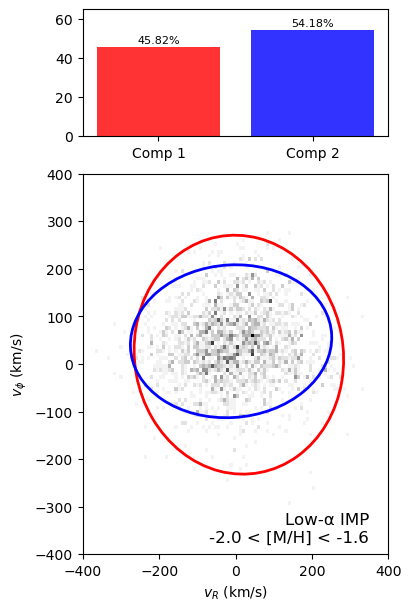


Low-α IMP (-2.0 < [M/H] < -1.6) (5028 stars)
   Component     Weights (%)  $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     45.8       8.56    137.17     19.68       125.55      1.83     124.15  
  Prograde halo     54.2     -11.85    131.79     47.90        80.37      0.64      75.82  


In [82]:
colors = ["red", "blue"]

plot_gmm_with_contributions(
    df_bin=df_imp_low,
    gmm=gmm_imp_low,
    bin_label="Low-α IMP",
    metallicity_range="-2.0 < [M/H] < -1.6",
    label="imp_low_alpha_k2",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_imp_low, df_imp_low, label="Low-α IMP (-2.0 < [M/H] < -1.6)")
print(summary)

In [7]:
#mp1 low alpha component 5

gmm_mp1_low = fit_gmm_fixed_components(df_mp1_low, n_components=5, n_init=100)

with open("../models/gmm_mp1_low.pkl", "wb") as f:
    pickle.dump(gmm_mp1_low, f)


Fitting GMM with 5 components: 100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


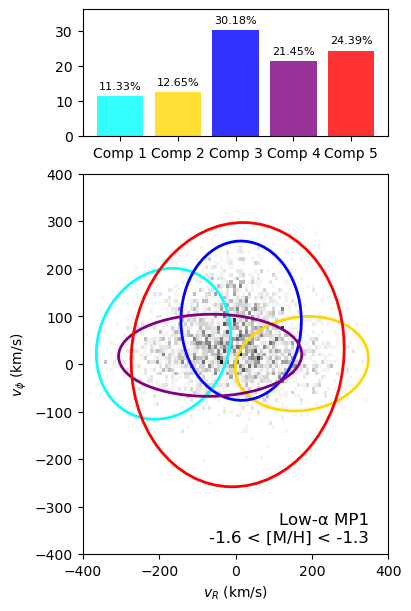


Low-α MP1 (-1.6 < [M/H] < -1.3) (5946 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     12.7      173.40     87.20      0.68        49.72      16.85    112.90  
  Prograde halo     21.4      -66.55    119.92     18.41        43.14      12.37     74.31  
         GS/E 1     24.4        5.41    139.42     19.70       138.87       2.94    135.64  
         GS/E 2     11.3     -188.64     87.98     42.56        79.32     -72.37     77.06  
     Thick Disc     30.2       14.54     78.81     91.12        83.70       5.48     63.63  


In [11]:
colors = ["aqua", "gold", "blue","purple", "red"]

plot_gmm_with_contributions(
    df_bin=df_mp1_low,
    gmm=gmm_mp1_low,
    bin_label="Low-α MP1",
    metallicity_range="-1.6 < [M/H] < -1.3",
    label="mp1_low_alpha_k4",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp1_low, df_mp1_low, label="Low-α MP1 (-1.6 < [M/H] < -1.3)")
print(summary)

In [71]:
#mp2 low alpha component 5

gmm_mp2_low = fit_gmm_fixed_components(df_mp2_low, n_components=5, n_init=100)

with open("../models/gmm_mp2_low.pkl", "wb") as f:
    pickle.dump(gmm_mp2_low, f)


Fitting GMM with 5 components:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting GMM with 5 components: 100%|██████████| 100/100 [04:36<00:00,  2.77s/it]


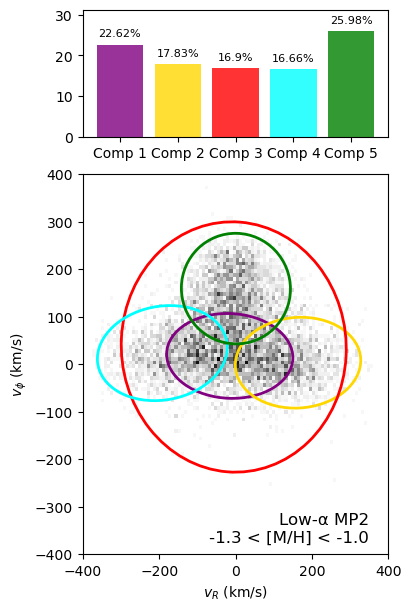


Low-α MP2 (-1.3 < [M/H] < -1.0) (12651 stars)
   Component     Weights (%)   $v_R$  $\sigma_R$  $v_\phi$  $\sigma_\phi$  $v_Z$  $\sigma_Z$
Stationary halo     17.8      163.48     82.07       3.39       47.81     -12.64    110.72  
  Prograde halo     22.6      -15.34     82.64      17.65       44.68      -1.25     60.79  
         GS/E 1     16.7     -191.82     85.03      23.55       50.04       2.49    104.42  
         GS/E 2     16.9       -4.81    147.30      36.45      131.74       0.75    134.58  
     Thick Disc     26.0        0.83     71.40     159.38       58.19      -1.14     55.54  


In [86]:
colors = ["purple", "gold", "red","aqua", "green"]

plot_gmm_with_contributions(
    df_bin=df_mp2_low,
    gmm=gmm_mp2_low,
    bin_label="Low-α MP2",
    metallicity_range="-1.3 < [M/H] < -1.0",
    label="mp2_low_alpha_k6",
    component_colors=colors
)

summary = extract_gmm_parameters(gmm_mp2_low, df_mp2_low, label="Low-α MP2 (-1.3 < [M/H] < -1.0)")
print(summary)